# 1 - Dataset metrics

This Jupyter notebook shows various dataset metrics presented in the paper.

In [1]:
import gzip
import json
import pymongo
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm.notebook import tqdm

In [2]:
mongo_client = pymongo.MongoClient(
    host="127.0.0.1",
    port=27017,
)
mongo_repositories = mongo_client["gha-scraper"]["repositories"]
mongo_runs         = mongo_client["gha-scraper"]["runs"]

In [3]:
# Helper functions
def get_class_ratios(elements):
    n = len(elements)
    for v, c in sorted(Counter(elements).items(), reverse=True, key=lambda x: x[1]):
        pct = round(100*c/n, 2)
        print(f"{c}/{n} ({pct}%) {v}")

In [4]:
# Get various stats
languages_repos = list(
    mongo_repositories.aggregate([
        {'$match': {'selected': True}},
        { "$group": { '_id': "$repo.mainLanguage", 'nb_repositories': {'$sum': 1}}}
    ])
)

languages_runs = list(
    mongo_repositories.aggregate([
        {'$match': {'selected': True}},
        {
          "$lookup":
             {
                'from': "runs",
                'localField': "_id",
                'foreignField': "repository_name",
                'as': "runs"
             }
        },
        {'$unwind': '$runs'},
        {'$match': {'runs.log_insights': {'$exists': True, '$ne': []}}},
        {
            '$group': {
                '_id': '$repo.mainLanguage',
                'nb_runs': {'$sum': 1},
            }
        }
    ])
)

languages_workflows = list(
    mongo_repositories.aggregate([
        {'$match': {'selected': True}},
        {
          "$lookup":
             {
                'from': "runs",
                'localField': "_id",
                'foreignField': "repository_name",
                'as': "runs"
             }
        },
        {'$unwind': '$runs'},
        {'$match': {'runs.log_insights': {'$exists': True, '$ne': []}}},
        {
            '$group': {
                '_id': {'mainLanguage': '$repo.mainLanguage', 'repository_name': '$runs.repository_name', 'workflow_path': '$runs.workflow_path'}              
            }
        },
        {
            '$group': {
                '_id': '$_id.mainLanguage',
                'nb_workflows': {'$sum': 1},
            }
        },
    ])
)

In [5]:
# Print to Latex table
total_repos = sum([x["nb_repositories"] for x in languages_repos])
total_runs = sum([x["nb_runs"] for x in languages_runs])
total_workflows = sum([x["nb_workflows"] for x in languages_workflows])

languages_repos = sorted(languages_repos, key=lambda x: x["nb_repositories"], reverse=True)
languages_runs_dict = {
    x["_id"]: x["nb_runs"] for x in languages_runs
}
languages_workflows_dict = {
    x["_id"]: x["nb_workflows"] for x in languages_workflows
}
for doc in languages_repos:
    language = doc['_id']
    nb_repositories = doc['nb_repositories']

    nb_runs = languages_runs_dict[language]
    nb_workflows = languages_workflows_dict[language]

    pct_repo = round(100*nb_repositories/total_repos, 2)
    pct_runs = round(100*nb_runs/total_runs, 2)
    pct_workflows = round(100*nb_workflows/total_workflows, 2)

    # Sorry for the uglyx formatting... Next we will use pandas.DataFrame.to_latex() ;)
    print(f"{language} & {str(round(nb_repositories/1000, 2)) + 'k' if nb_repositories>1000 else nb_repositories} ({pct_repo}\\%) & "
          f"{str(round(nb_workflows/1000, 2)) + 'k' if nb_workflows>1000 else nb_repositories} ({pct_workflows}\\%) & " +
          f"{str(round(nb_runs/1000, 2)) + 'k' if nb_runs>1000 else nb_repositories} ({pct_runs}\\%) \\\\")

print(f"Total & {round(total_repos/1000, 3)}k & {round(total_workflows/1000, 3)}k & {round(total_runs/1000, 3)}k \\\\")

Python & 5.52k (19.5\%) & 22.34k (19.21\%) & 97.31k (18.95\%) \\
TypeScript & 4.44k (15.66\%) & 18.9k (16.25\%) & 84.19k (16.4\%) \\
Go & 2.95k (10.41\%) & 15.77k (13.56\%) & 70.38k (13.71\%) \\
JavaScript & 2.78k (9.8\%) & 9.78k (8.41\%) & 44.2k (8.61\%) \\
C++ & 2.14k (7.55\%) & 9.22k (7.93\%) & 40.98k (7.98\%) \\
Java & 2.07k (7.32\%) & 8.34k (7.17\%) & 36.66k (7.14\%) \\
Rust & 2.02k (7.14\%) & 7.97k (6.86\%) & 34.9k (6.8\%) \\
C & 1.25k (4.41\%) & 5.17k (4.45\%) & 23.3k (4.54\%) \\
PHP & 1.2k (4.22\%) & 4.56k (3.92\%) & 20.12k (3.92\%) \\
C# & 1.1k (3.88\%) & 3.79k (3.26\%) & 15.88k (3.09\%) \\
Shell & 735 (2.6\%) & 2.71k (2.33\%) & 11.95k (2.33\%) \\
Ruby & 639 (2.26\%) & 2.3k (1.98\%) & 10.45k (2.04\%) \\
Kotlin & 634 (2.24\%) & 2.27k (1.95\%) & 9.72k (1.89\%) \\
Dart & 319 (1.13\%) & 1.38k (1.18\%) & 5.93k (1.15\%) \\
Swift & 250 (0.88\%) & 250 (0.69\%) & 3.29k (0.64\%) \\
Elixir & 126 (0.44\%) & 126 (0.3\%) & 1.56k (0.3\%) \\
Objective-C & 60 (0.21\%) & 60 (0.24\%) & 1.21k (0.

In [6]:
# Log parsing stats
parsing_errors = []
for run in tqdm(mongo_runs.find({"log_insights": {"$exists": True, "$ne": []}})):
    for job in run["log_insights"]:
        for step in job.get("steps", []):
            if step["type"] == "shell":
                if step.get("error"):
                    parsing_errors.append(step["error"]["error"])
                else:
                    parsing_errors.append("Success")
get_class_ratios(parsing_errors)

0it [00:00, ?it/s]

6033548/6256046 (96.44%) Success
205807/6256046 (3.29%) Parser exception
16691/6256046 (0.27%) Invalid request


In [7]:
# Log download errors
log_download_errors = []
for run in tqdm(mongo_runs.find({"logs_archive.error": {"$exists": True}}), leave=False):
    error = run["logs_archive"]["error"]
    if "File name too long" in error:
        error = "File name too long"  # Remove path from error message
    log_download_errors.append(error)
get_class_ratios(log_download_errors)

0it [00:00, ?it/s]

36653/50846 (72.09%) More than 90d old
8987/50846 (17.67%) Got HTTP 410
4041/50846 (7.95%) Got HTTP 404
636/50846 (1.25%) unexpected end of data
414/50846 (0.81%) Got HTTP 403
51/50846 (0.1%) File name too long
38/50846 (0.07%) cannot access local variable 'req' where it is not associated with a value
17/50846 (0.03%) Logs archive is too big
4/50846 (0.01%) Fail after 5 attempts (HTTP 403)
4/50846 (0.01%) Fail after 5 attempts (HTTP 500)
1/50846 (0.0%) Fail after 5 attempts (HTTP 502)


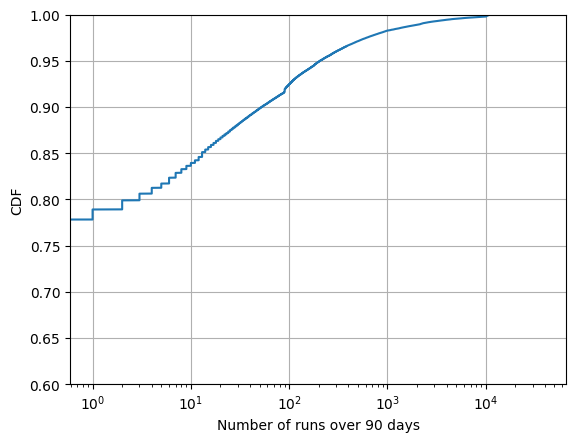

In [8]:
# CDF number of runs over 90d
total_runs = [doc["total_runs_90d"] for doc in mongo_repositories.find({"total_runs_90d": {"$gte": 0}}, projection={"total_runs_90d": True})]

N = len(total_runs)
X = np.sort(total_runs)
Y = np.array(range(N))/float(N)

plt.plot(X, Y)
plt.ylabel("CDF")
plt.xlabel("Number of runs over 90 days")
plt.ylim(0.6, 1)
plt.xscale("log")
plt.grid(True)
# plt.savefig("cdf_repos.png")
plt.show()

In [12]:
# Percentage of commands with at least one annotation
commands_with_annotations = 0
commands_total = 0
for run in tqdm(mongo_runs.find({"log_insights": {"$exists": True, "$ne": []}})):
    for job in run["log_insights"]:
        for step in job.get("steps", []):
             if step["type"] == "shell":
                 for command in step.get("commands", []):
                     commands_total += 1
                     if command.get("annotations", []):
                         commands_with_annotations += 1
print(f"{round(100*commands_with_annotations/commands_total)}% of commands have annotations")

0it [00:00, ?it/s]

71% of commands have annotations
